In [1]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(50)
from fit_on_batches import fit_on_batches
from UNet import UNet

Using CNTK backend


In [2]:
imgPath = 'DATA/Stored/train/'
maskPath = 'DATA/Stored/train_masks/'
#DIM = (1280, 1920, 3)
DIM = (128, 128, 3)
print('Total {} samples'.format(len([i for i in os.listdir(imgPath)])))

Total 10176 samples


In [3]:
# Define IoU metric and loss
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [4]:
model = UNet(DIM, start_ch=8)
model.compile(Adam(), dice_loss, [dice_coef])
print('Total params - {:,}'.format(model.count_params()))
#model.summary()

Total params - 485,817


In [5]:
hystory = fit_on_batches(model=model, x_data=imgPath, y_data=maskPath, mode='mask', target_img_size=DIM[:2],
                         epochs=150, batch_size=64, data_split=576/10176, validation_split=64/576, patience = None, verbose = 0)

DATA/Stored/train/880fec285c06_15_GEN.jpg
DATA/Stored/train_masks/880fec285c06_15_mask_GEN.jpg
Train on 512 samples, validate on 64 samples:
 - 10585s | loss: 0.0180 | dice_coef: 0.9820 | val_loss: 0.0274 | val_dice_coef: 0.9726


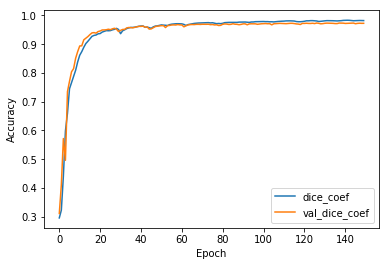

In [7]:
if (hystory['BE'] != 0):
    print("Обучение остановлено на", hystory['BE'], "эпохе")

for i in list(range(len(hystory)))[2::2]:
    key = list(hystory.keys())[i]
    plt.plot(hystory[key], label=key)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
# Saving model
model_json = model.to_json()
json_file = open("Models/UNetModel.json", "w")
json_file.write(model_json)
json_file.close()
model.save_weights("Models/UNetModel.h5")